In [1]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch
import yaml
from pathlib import Path

from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
# The code cell is used to add the src directory to the Python path, making
# it possible to import modules from that directory.

# used to add the src directory to the Python path, making
# it possible to import modules from that directory.
module_path = Path("..", "src").resolve().as_posix()
sys.path.insert(0, module_path)

# Try importing the custom modules from the src directory
# NOTE how `utils` is getting imported. This is to avoid conflict with built-in python library named 'utils'
try:
    from custom_dataset import CropData
    import utils as u
    from models.unet import Unet
    from model_compiler import ModelCompiler
    from custom_loss_functions import *
except ModuleNotFoundError:
    print("Module not found")
    pass


def load_config(yaml_config_path, num_time_points):
    with open(yaml_config_path, "r") as file:
        config = yaml.load(file, Loader=yaml.SafeLoader)

    # Perform multiplication and concatenation for each key in global_stats
    for key, value in config["global_stats"].items():
        config["global_stats"][key] = value * num_time_points

    # Resolve paths in the config file to be absolute so it's system agnostic
    keys_with_paths = ["src_dir", "train_csv_path", "test_csv_path", "val_csv_path"]
    for key in keys_with_paths:
        config[key] = Path(config[key]).resolve().as_posix()

    if config["params_init"]:
        config["params_init"] = Path(config["params_init"]).resolve().as_posix()

    return config


In [ ]:
# The code cell loads a configuration file (default_config.yaml) using the YAML library and stores the
# configuration data in the config dictionary. Then, it processes the global_stats section of the config
# dictionary by expanding the lists for each stats based on the number of available time points.
# As you can see we decided to generate a single set of normalization statistics and use it to
# normalize all the time-points.

yaml_config_path = Path("../config/default_config.yaml").resolve()  # replace this path to your own config file.

num_time_points = 3  # Change this number accordingly if you use a dataset with a different temporal length.
config = load_config(yaml_config_path, num_time_points)


In [ ]:
# OPTIONAL
# pretty-print the config dictionary

import pprint

pprint.pprint(config, width=100, compact=True)


{'LR': 0.011,
 'LR_policy': 'PolynomialLR',
 'apply_normalization': True,
 'aug_params': {'rotation_degree': [-180, -90, 90, 180]},
 'checkpoint_interval': 20,
 'class_mapping': {0: 'Unknown',
                   1: 'Natural Vegetation',
                   2: 'Forest',
                   3: 'Corn',
                   4: 'Soybeans',
                   5: 'Wetlands',
                   6: 'Developed/Barren',
                   7: 'Open Water',
                   8: 'Winter Wheat',
                   9: 'Alfalfa',
                   10: 'Fallow/Idle Cropland',
                   11: 'Cotton',
                   12: 'Sorghum',
                   13: 'Other'},
 'criterion': {'gamma': 0.9,
               'ignore_index': 0,
               'name': 'TverskyFocalLoss',
               'weight': [0.0182553, 0.03123664, 0.02590038, 0.03026126, 0.04142966, 0.04371284,
                          0.15352935, 0.07286951, 0.10277024, 0.10736637, 0.1447082, 0.17132445,
                          0.0566358]}

### Steps for training and finetuning

In [5]:
# STEP 1-1: Data Preparation and Loading
# This code cell reads the input dataset for training, pre-processes it, and creates a 'torch.utils.Dataset'
# object to be used in the model training process. It utilizes the 'CropData' class from the custom module
# (CropData.py) to achieve this.

train_dataset = CropData(
    src_dir=config["src_dir"],
    usage="train",
    dataset_name=config["train_dataset_name"],
    csv_path=config["train_csv_path"],
    apply_normalization=config["apply_normalization"],
    normal_strategy=config["normal_strategy"],
    stat_procedure=config["stat_procedure"],
    global_stats=config["global_stats"],
    trans=config["transformations"],
    **config["aug_params"]
)


100%|██████████| 332/332 [00:07<00:00, 47.20it/s]

------ train dataset with 332 patches created ------


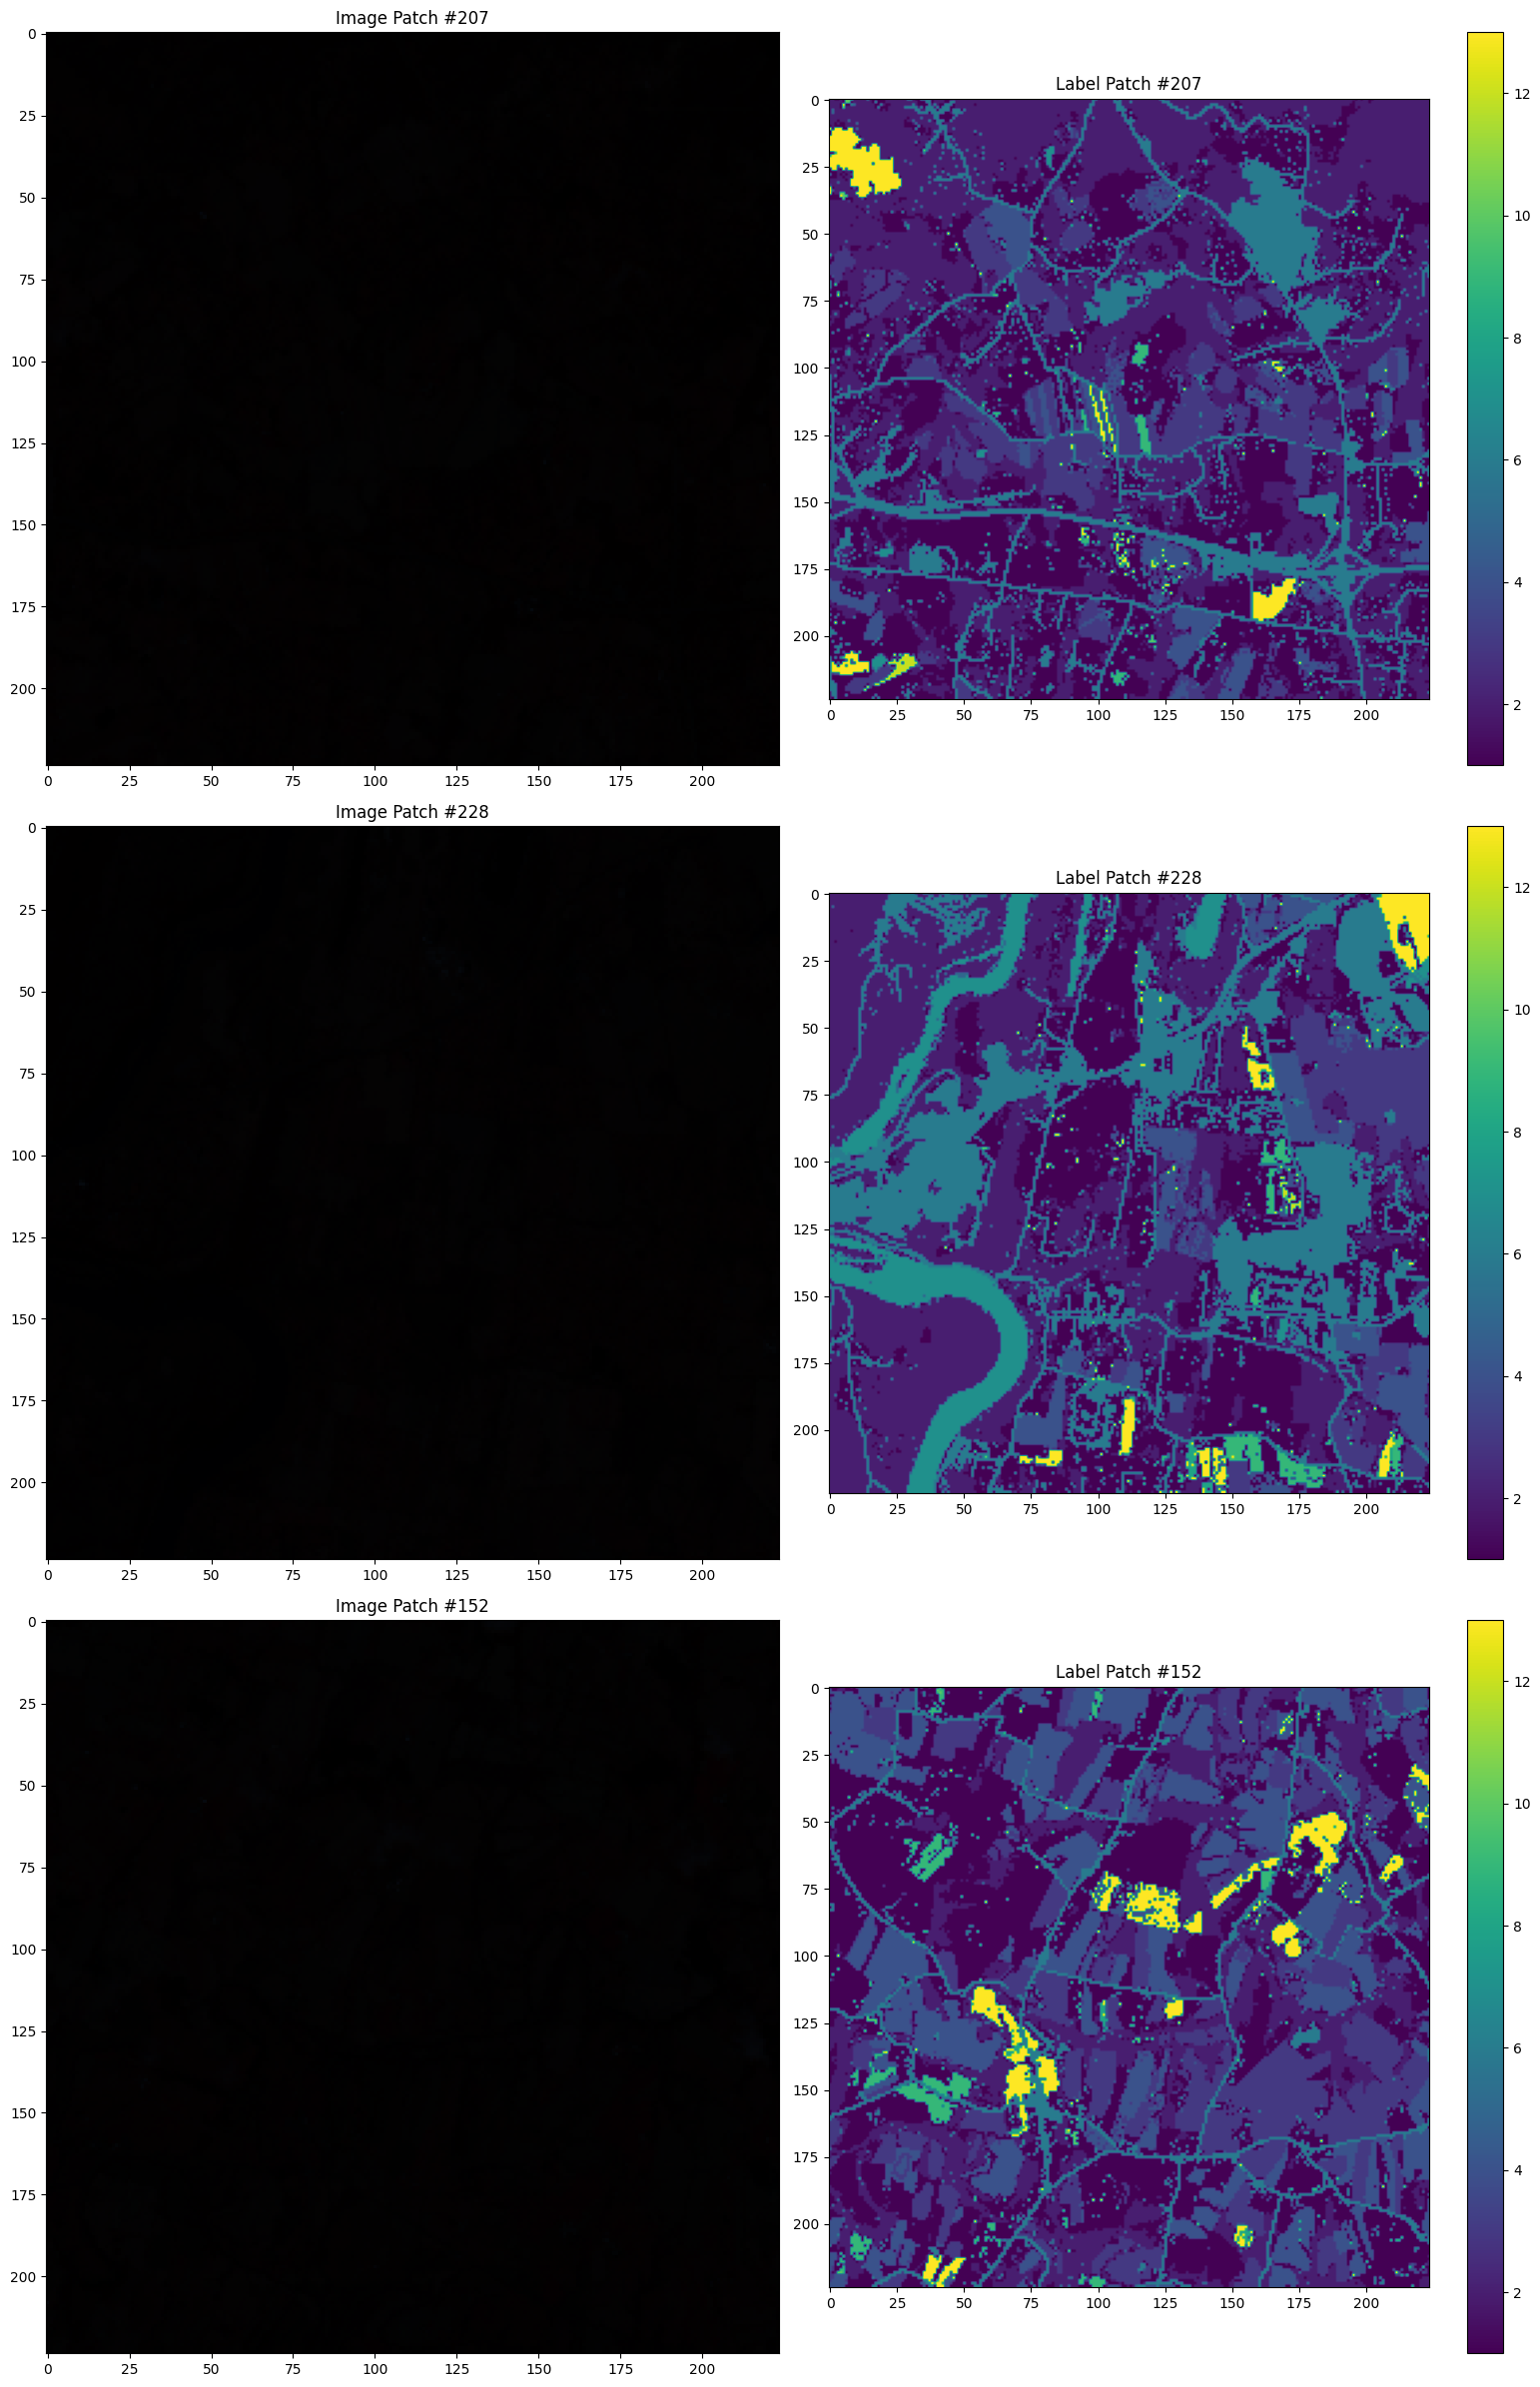

In [ ]:
# OPTIONAL

u.show_random_patches(train_dataset, sample_num=3, rgb_bands=(3, 2, 1))


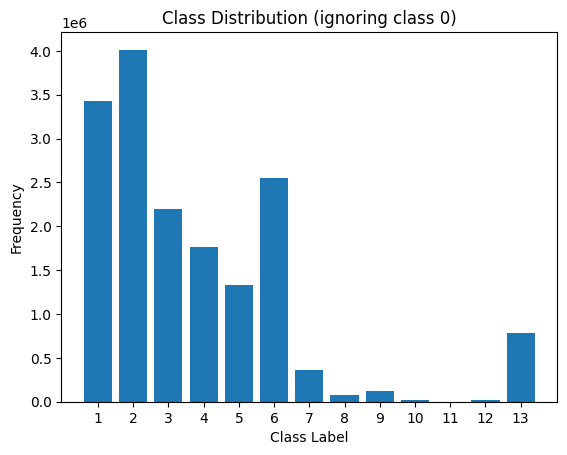

In [ ]:
# OPTIONAL
# Check the distribution of categories in a dataset

labels_count = u.get_labels_distribution(train_dataset, num_classes=14, ignore_class=0)
u.plot_labels_distribution(labels_count)


In [ ]:
# STEP 1-2: Data Batching and Device Assignment
# This code cell batchifies the training dataset using the 'DataLoader' class from PyTorch. The 'DataLoader'
# efficiently loads the 'train_dataset' in batches, facilitating memory management during training.

train_loader = DataLoader(
    train_dataset, batch_size=config["train_BatchSize"], shuffle=True
)


In [ ]:
# STEP 1-3
# Read the input dataset for validation, pre-process it and generate a 'torch.utils.Dataset' object
# that can be accepted to get loaded into the model.

val_dataset = CropData(
    src_dir=config["src_dir"],
    usage="validation",
    dataset_name=config["train_dataset_name"],
    csv_path=config["val_csv_path"],
    apply_normalization=config["apply_normalization"],
    normal_strategy=config["normal_strategy"],
    stat_procedure=config["stat_procedure"],
    global_stats=config["global_stats"],
)


100%|██████████| 83/83 [00:01<00:00, 45.85it/s]

------ validation dataset with 83 patches created ------


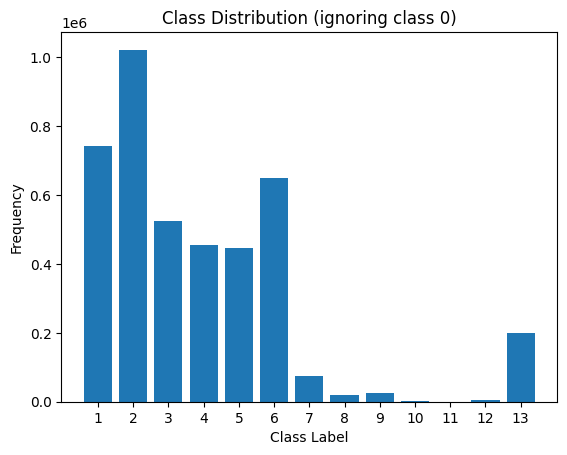

In [ ]:
# OPTIONAL
# Check the distribution of categories in a dataset

labels_count = u.get_labels_distribution(val_dataset)
u.plot_labels_distribution(labels_count)


In [ ]:
# STEP 1-4
# Batchify the validation dataset and put it on the defined 'Device'.

val_loader = DataLoader(val_dataset, batch_size=config["val_test_BatchSize"], shuffle=False)


In [ ]:
# STEP 2: Model Initialization
# The model is based on the U-Net architecture, a popular choice for image segmentation tasks.

model = Unet(
    n_classes=config["n_classes"],
    in_channels=config["input_channels"],
    use_skipAtt=config["use_skipAtt"],
    filter_config=config["filter_config"],
    dropout_rate=config["train_dropout_rate"],
)


In [11]:
# STEP 3: Model Compilation and Training Setup
# This code cell compiles the deep learning model, making it ready for training and evaluation. The 'ModelCompiler'
# class is employed for this purpose, which offers a set of essential functionalities, such as model training
# ('fit'), model saving, accuracy evaluation ('accuracy_evaluation'), inference ('inference'), and checkpointing
# with resume capabilities. Additionally, it generates tensorboard reports and graphs for monitoring the training
# process.

# Note: For training from scratch pass the "params_init" and "freeze_params" as None which results in loading a vanilla
# model with random initialization based on the "model_init_type" parameter. For training with warmup, only change the
# "params_init" to the path to model's saved parameter (not a checkpoint). For fine-tuning, change the "params_init" to
# the path to model's saved parameter (by default its in the chckpt folder in working directory) and pass a list of integers
# representing the index of layers to be frozen.

compiled_model = ModelCompiler(
    model,
    working_dir=config["working_dir"],
    out_dir=config["out_dir"],
    num_classes=config["n_classes"],
    inch=config["input_channels"],
    class_mapping=config["class_mapping"],
    gpu_devices=config["gpuDevices"],
    model_init_type=config["init_type"],
    params_init=config["params_init"],
    freeze_params=config["freeze_params"],
)


----------GPU available----------
initialize network with kaiming.
total number of trainable parameters: 103.4M
---------- Vanilla Model compiled successfully ----------


In [13]:
# STEP 4: Model Training and Validation
# This code cell trains and validates the compiled deep learning model for the specified number of epochs.
# The model is trained using the "fit" method provided by the 'compiled_model' object. The training data
# is obtained from 'train_loader', which contains batched samples and labels. Additionally, the 'val_loader'
# is used for model validation during training. For each epoch the model reports the average loss value for both
# training and validation phases, providing insights into its generalization capabilities.

# During the training the "fit" method will create a folder called 'chkpt' inside your working directory
# and save the checkpoints in user-defined intervals in that folder.
# Note: In case the training process is interrupted, you can change the "resume" argument and pass in the
# epoch to resume based on the created checkpoints.

criterion_name = config["criterion"]["name"]
weight = config["criterion"]["weight"]
ignore_index = config["criterion"]["ignore_index"]
gamma = config["criterion"]["gamma"]

if criterion_name == "TverskyFocalLoss":
    criterion = TverskyFocalLoss(weight=weight, ignore_index=ignore_index, gamma=gamma)
else:
    criterion = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)


compiled_model.fit(
    train_loader,
    val_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr_init=config["LR"],
    lr_policy=config["LR_policy"],
    criterion=criterion,
    momentum=config["momentum"],
    checkpoint_interval=config["checkpoint_interval"],
    resume=config["resume"],
    resume_epoch=config["resume_epoch"],
    **config["lr_prams"]
)


-------------------------- Start training --------------------------
Epoch [1/2]
train loss:0.9641472977750442
validation loss: 0.9605
LR: 0.01088407840200658
time: 158
Epoch [2/2]
train loss:0.8995319587342879
validation loss: 0.8867
LR: 0.01088407840200658
time: 114
----------- Training finished in 0:04:33 -----------


In [15]:
# STEP 5
# Same model parameters
compiled_model.save(save_object="params")


saveing params to C:\github\PublicRepos\multi-temporal-crop-classification-baseline\output\Unet_ep2\chkpt
C:/github/PublicRepos/multi-temporal-crop-classification-baseline/output/Unet_ep2/chkpt/Unet_final_state.pth
--------------------- Model parameters is saved to disk ---------------------


---------------- Start evaluation ----------------


C:\github/PublicRepos/multi-temporal-crop-classification-baseline/src\accuracy_metric.py:25: RuntimeWarning: invalid value encountered in divide
  acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
C:\github/PublicRepos/multi-temporal-crop-classification-baseline/src\accuracy_metric.py:36: RuntimeWarning: invalid value encountered in divide
  tp / (tp + fp),
C:\github/PublicRepos/multi-temporal-crop-classification-baseline/src\accuracy_metric.py:49: RuntimeWarning: invalid value encountered in divide
  tp / (tp + fn),
C:\github/PublicRepos/multi-temporal-crop-classification-baseline/src\accuracy_metric.py:63: RuntimeWarning: invalid value encountered in divide
  2 * (precision * recall) / (precision + recall),


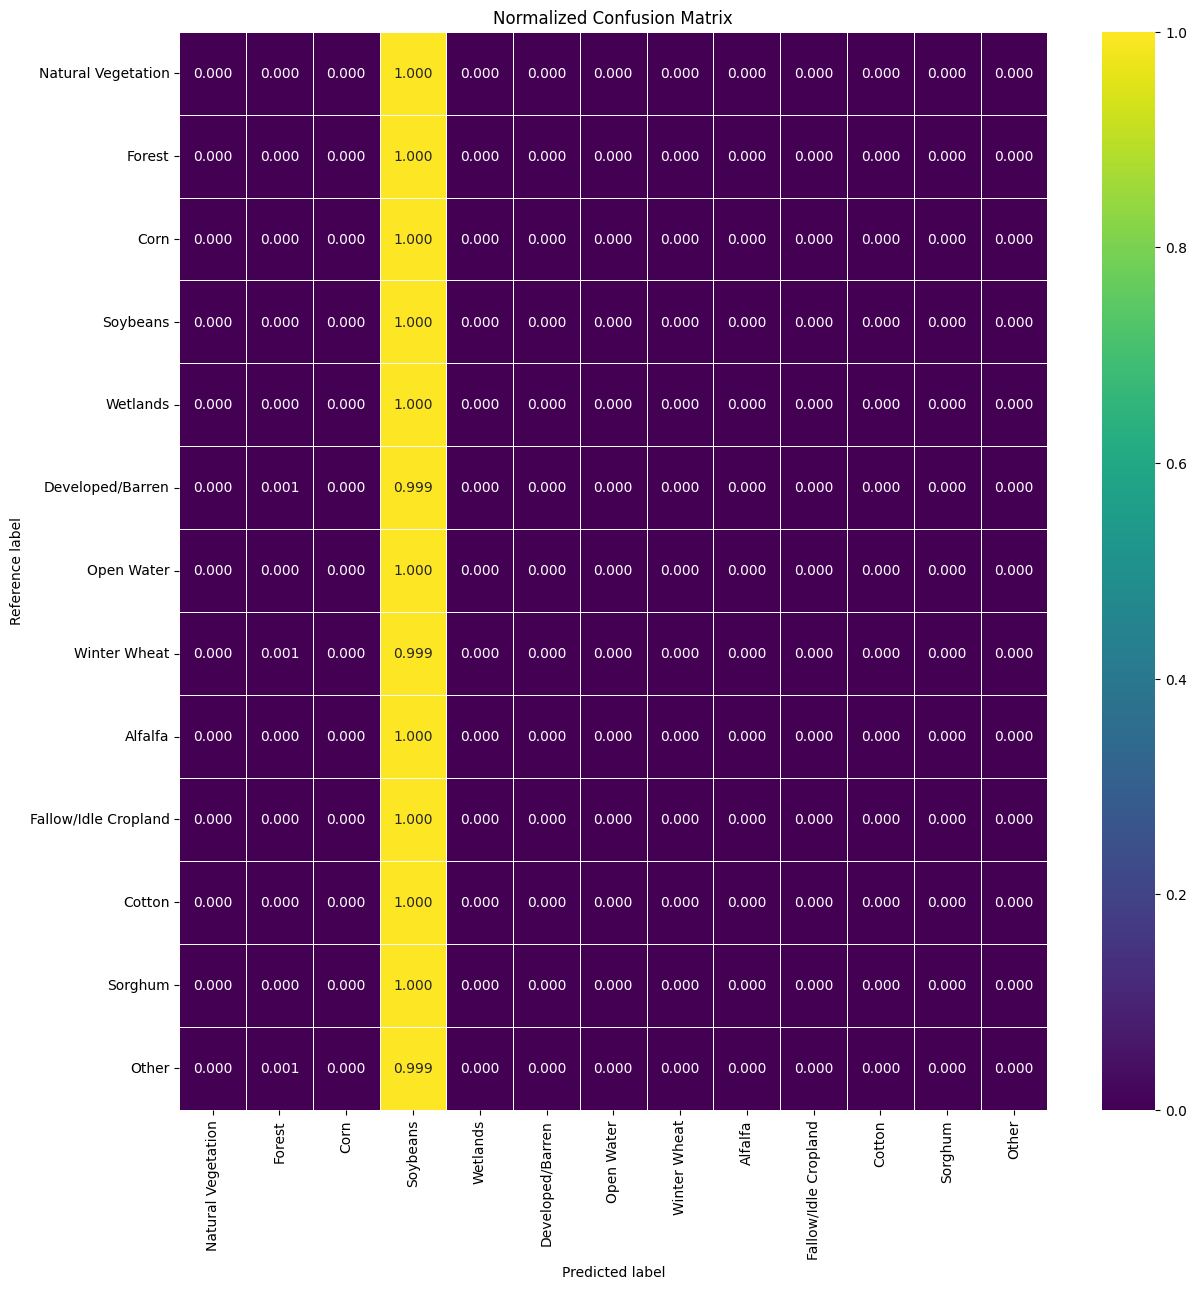

---------------- Evaluation finished in 4s ----------------


In [ ]:
# STEP 6
# Generate the accuracy metrics.
compiled_model_metrics = compiled_model.accuracy_evaluation(val_loader, filename=config["val_metric_fname"])


### Steps for prediction

In [ ]:
yaml_config_path = Path("../config/default_config.yaml").resolve()  # replace this path to your own config file.

num_time_points = 3  # Change this number accordingly if you use a dataset with a different temporal length.
config = load_config(yaml_config_path, num_time_points)


test_dataset = CropData(
    src_dir=config["src_dir"],
    usage="inference",
    dataset_name=config["train_dataset_name"],
    csv_path=config["test_csv_path"],
    apply_normalization=config["apply_normalization"],
    normal_strategy=config["normal_strategy"],
    stat_procedure=config["stat_procedure"],
    global_stats=config["global_stats"],
)


100%|██████████| 83/83 [00:01<00:00, 43.84it/s]

------ inference dataset with 83 patches created ------


In [ ]:
def meta_handling_collate_fn(batch):
    images = []
    labels = []
    img_ids = []
    img_metas = []

    # Unpack elements from each sample in the batch
    for sample in batch:
        images.append(sample[0])
        labels.append(sample[1])
        img_ids.append(sample[2])
        img_metas.append(sample[3])  # append the dict to the list

    # Stack images and labels into a single tensor
    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)

    return images, labels, img_ids, img_metas


test_loader = DataLoader(
    test_dataset,
    batch_size=config["val_test_BatchSize"],
    shuffle=False,
    collate_fn=meta_handling_collate_fn,
)


In [ ]:
model = Unet(
    n_classes=config["n_classes"],
    in_channels=config["input_channels"],
    use_skipAtt=config["use_skipAtt"],
    filter_config=config["filter_config"],
    dropout_rate=config["train_dropout_rate"],
)


In [ ]:
# Note: For inference, pass the path to the model's saved parameter (not a checkpoint) in the "params_init" argument.
# Will need to reload yaml config file to get the correct path to the model's saved parameter.

compiled_model = ModelCompiler(
    model,
    working_dir=config["working_dir"],
    out_dir=config["out_dir"],
    num_classes=config["n_classes"],
    inch=config["input_channels"],
    class_mapping=config["class_mapping"],
    gpu_devices=config["gpuDevices"],
    model_init_type=config["init_type"],
    params_init=config["params_init"],
    freeze_params=config["freeze_params"],
)


UnpicklingError: invalid load key, 'v'.

In [ ]:
compiled_model.inference(test_loader)


---------------- Start prediction ----------------
Pred tile: 000_023 is written to ..\output
Pred tile: 000_043 is written to ..\output
Pred tile: 000_056 is written to ..\output
Pred tile: 000_057 is written to ..\output
Pred tile: 001_035 is written to ..\output
Pred tile: 001_045 is written to ..\output
Pred tile: 001_053 is written to ..\output
Pred tile: 001_054 is written to ..\output
Pred tile: 001_057 is written to ..\output
Pred tile: 002_021 is written to ..\output
Pred tile: 002_022 is written to ..\output
Pred tile: 002_026 is written to ..\output
Pred tile: 002_032 is written to ..\output
Pred tile: 002_049 is written to ..\output
Pred tile: 003_021 is written to ..\output
Pred tile: 003_033 is written to ..\output
Pred tile: 003_034 is written to ..\output
Pred tile: 003_037 is written to ..\output
Pred tile: 003_053 is written to ..\output
Pred tile: 003_057 is written to ..\output
Pred tile: 004_004 is written to ..\output
Pred tile: 004_019 is written to ..\output
Pre